# **Modul: 4050 - Photogrammetrie - Computer Vision und English**

**Autoren:**  
Elia Ferrari  
 Jonas Meyer  
 Prof. Dr. Stephan Nebiker

Datum: 20.03.2023

# **Uebung Omnivision**

### Einleitung und Zielsetzung

In dieser Übung werden Sie ein Panorama generieren. Dafür gibt es unterschiedliche Möglichkeiten. Eine ist das Erfassen von mehreren Bildern und anschliessendes Stitching. Sie werden in der Übung Bilder der Mehrkopfpanoramakamera Ladybug5 mittels Python zu einem Panorama zusammenfügen und auf einen Zylindermantel projizieren. Für das Stitching werden die bekannten relativen Orientierungen der Bilder verwendet. Ist das Zylinderpanorama erstellt, wird es als Bilddatei ausgegeben. Das Panorama wird dann mit Pano2QTVR aufbereitet, um es schliesslich mit dem QuickTime Player zu visualisieren.

Am Schluss dieser Übung sollten Sie:

* Mehrere Bilder mit bekannter relativer Orientierung zu einem Zylinder-Panorama zusammenfügen können
* Ein Zylinder-Panorama mit Pano2QTVR für die Visualisierung im QuickTime Player aufbereiten können
  


### Benötigte Module

* numpy
* skimage
* matplotlib

### Ausgangsdaten
* Bilddaten der Panoramakamera Ladybug5: ./data/images/
* Relative Orientierungen der Bilddaten: ./data/rel_ori/
* Innere Orientierung der 5 Kameras: ./data/camera_matrices/

### Abgabe

Jede Studentin und jeder Student muss funktionierendes Code-Repository rechtzeitig auf GitHub (via push-Funktion) abgeben.
Die Funktionstüchtigkeit des eigenen Codes ist sowohl mit Hilfe der vorhandenen unittests sowie anhand der Resultate vorgängig zu beurteilen.

### Vorgehen

Die Generierung und Visualisierung des Panoramas mit bekannter innerer und relativer Orientierung der fünf Bilder kann in folgende Schritte unterteilt werden:
1.	Definition der Ausgangsdaten
2.	Zylinder im Objektraum berechnen bzw. Punkte auf dem Zylindermantel berechnen
3.  Pro Bild: <br>
   a) Bild einlesen<br>
   b) Werte der inneren und relativen Orientierung einlesen und aufbereiten<br>
   c) Panoramateilstücke generieren<br>
4.  Zusammenfügen aller Panoramateilstücke
5.  Ausgabe des ganzen Panoramas als Bilddatei

### Zur Info

* Zu ergänzende Code-Stellen sind mit ``#TODO`` gekennnzeichnet.
* Bei Unklarheiten bezüglich der Bedeutung englischer Begriffe aus dem Bereich Photogrammetrie kann [dieses Dokument](https://onlinelibrary.wiley.com/doi/10.1111/phor.12314) konsultiert werden.
* Für die Durchführung der unittests siehe Anleitung in [README.md](README.md).

### Import notwendiger Module

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

### Schritt 1 - Ausgangsdaten

Das Panorama wird aus fünf Bildern der Ladybug5 generiert. Das Bild des 6. Kamerakopfs, der senkrecht nach oben gerichtet ist, wird nicht miteinbezogen. Die Bilder werden standardmässig liegend bzw. um 90° gedreht aus dem Workflow der Ladybug5 ausgegeben. Sie werden auch so weiterverarbeitet. Die vorliegenden inneren und relativen Orientierungen beziehen sich auf diese "liegenden" Bilder. Die Bilder sind bereits rektifiziert, weshalb sie eine Schmetterlingsform aufweisen.

<figure align="center">
<img src="data/images/2.jpg" alt="Rektifiziertes Bild" width="400"/>
<figcaption>Abb. 1 - Rektifiziertes Bild des Kamerakopfs Nr. 2 der Ladybug5.</figcaption>
</figure>

Für die Generierung eines Panoramas aus mehreren Bildern muss die relative Orientierung (Verschiebung und Verdrehung) zwischen den einzelnen Bildern bekannt sein. Zusätzlich sind für die Berechnung des Panoramas auch die Werte der inneren Orientierung erforderlich. Die inneren und relativen Orientierungen der Bilder wurden vorgängig über ein Kalibrierungsverfahren bestimmt und liegen nun als Text-Dateien vor.<br>
<br>
Die relativen Orientierungen sind in den Dateien Rel_Ori_x.ro wie folgt aufgeführt: 

|  | Projektionszentrum | Orientierungswinkel |
| :-: | :-: | :-: |
| CamNr | X, Y,  Z | Omega, Phi, Kappa |

<br>
Die inneren Orientierungen sind in den Dateien <i>CameraMatrix0x.txt</i> in Form von Kameramatrizen in der Einheit Pixel vorhanden:<br>


$$\begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$$  
<center>
fx, fy: Kamerakonstante in X- und Y-Richtung<br>
cx, cy: Bildhauptpunkt in X- und Y-Richtung
</center>


#### Definition der Ausgangsdaten
1. Öffnen Sie in einem ersten Schritt die Dateien der inneren und relativen Orientierung in einem Text-Editor und interpretieren Sie die Werte
2. Für die Verwaltung der Bilder wird das Modul ``skimage`` verwendet.<br>
   Definieren Sie den Pfad zu den Bildern laden Sie diese in eine Liste

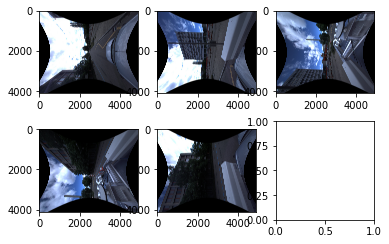

In [2]:
coll_src_img = io.ImageCollection('data/images/*.jpg')
io.imshow_collection(coll_src_img)
plt.show();

3.	Definieren Sie die Werte für den Zylinder im Objektraum, auf welchen das Panorama projiziert wird, wie folgt:

In [3]:
# CONSTANTS
cylinder_radius_m = 10 #Meter
cylinder_height_m = 2.5 * cylinder_radius_m #Meter - Verhaeltniss fuer Ladybug5: HEIGHT = 2.5*RADIUS
cylinder_res_px = 1500 #Pixel - definiert die Aufloesung des Panoramas (Laenge)

increment_m = (2 * math.pi * cylinder_radius_m)/cylinder_res_px #TODO: in Meter
increment_rad = 2*math.pi/cylinder_res_px #TODO: in rad

# Definition der Groesse des Panoramas (Ausdehnung des Zylindermantels)
h_pano_px = int(round(cylinder_height_m/increment_m)) #TODO: Anzahl Pixel in der Hoehe
l_pano_px = cylinder_res_px #TODO: Anzahl Pixel in der Breite

4.	Erstellen Sie zwei Variablen für die Höhe und Länge des gesamten Panoramas in Pixel. (Das Panorama entspricht der Ausdehnung des Zylindermantels.)<br>
    Die Anzahl Pixel in der Höhe kann über die Höhe des Zylinders in Meter und die Schrittweite in Meter bestimmt werden. Die Länge des Panoramas entspricht der Länge des definierten Zylindermantels (``cylinder_res_px``).<br>
    Runden Sie die beiden Werte mit der Funktion ``round()`` bevor Sie diese in die Variablen abfüllen. 

### Schritt 2 - Bestimmung der Punkte des Zylindermantels im Objektraum

Für die Generierung des Panoramas wird im Objektraum ein Zylinder definiert (bspw. mit einem Radius von 10 m und einer Höhe von 25 m). Schliesslich werden Punkte des Zylindermantels generiert.<br>
Anstatt diese Punkte mit Koordinaten zu speichern, wird pro Punkt ein <i>Winkel α</i> und eine <i>Höhe</i> gespeichert.

1.	Erstellen Sie für die Zylinderpunkte eine neue Matrix mit der Funktion ``cyl_obj_pts = np.zeros((…,…))``.<br>
Die Ausdehnung der Matrix soll so definiert werden, dass pro Punkt des Panoramas/Zylindermantels zwei Angaben (Winkel und Höhe) gespeichert werden können.
2. Für die Generierung der Zylindermantelpunkte werden zwei verschachtelte Schleifen verwendet.<br>
   In der ersten Schleife wird ein Winkel ξ (``xi``) definiert. In der zweiten Schleife werden (pro definiertem Winkel), im Abstand der Schrittweiten in Meter, Höhen η (``Eta``) generiert und in der vorhin definierten Matrix gespeichert: 

In [4]:
cyl_obj_pts = np.zeros((l_pano_px*h_pano_px, 2)) #TODO #alpha, Hoehe bzw. xi & eta

no_pts = 0
for i in range(cylinder_res_px):
    
    xi = (i+1)*increment_rad - (36/180*math.pi) # -36°: Der Bildausschnitt eines Bildes deckt 72° ab. Start des Zylinders  
    
    # np.arange(start, stop, step)
    for eta in np.arange(cylinder_height_m/2, -cylinder_height_m/2, -increment_m):
         cyl_obj_pts[no_pts][0] = xi
         cyl_obj_pts[no_pts][1] = eta
         no_pts += 1

### Schritt 3 - Generierung der Panoramateilstücke

Das gesamte Panorama wird aus fünf Panoramateilstücken zusammengesetzt. Pro Bild wird ein solches Panoramateilstück generiert. Dabei werden für jedes Bild die Farbwerte der entsprechenden Zylindermantelpunkte bzw. der Panoramapunkte bestimmt. Mittels der Kollinearitätsgleichung und den bekannten inneren und relativen Orientierungen können die Zylindermantelpunkte des Objektraums in die ursprünglichen Bilder zurückgerechnet und die Farbwerte der Punkte abgefragt werden. Ist das gesamte Panoramateilstück generiert, wird gespeichert und dargestellt.

1. Pro Bild wird ein Panoramateilstück generiert. Da der Vorgang dabei immer derselbe bleibt, wird eine for-Schleife mit fünf Durchgängen dafür verwendet. Erstellen Sie die Struktur dieser for-Schleife.
2. Für die weiteren Schritte in der Schleife wird eine Variable <i>``camNr``</i> eingeführt. Sie beinhaltet die jeweilig aktuelle Kameranummer und wird mittels der Laufnummer der vorhin definierten for-Schleife abgefragt<br>
   <b>Hinweis: achten sie auf die korrekte Indexierung</b>
3. Laden Sie die Elemente der relativen Orientierung aus der entsprechenden Text-Datei aus und füllen Sie diese in Variablen ab. Ergänzen Sie die Parametern  in der Funktion ``read_extrinsic_param`` in ``src/utils.py`` gemäss folgender Formel:

$$R = \begin{bmatrix} r_{11} & r_{12} & r_{13} \\ r_{21} & r_{22} & r_{23} \\ r_{31} & r_{32} & 3_{33} \end{bmatrix}$$
$$ = \begin{bmatrix} cosϕ*cosk & -cosϕ*sink & sinϕ \\ cos\omega*sink+sin\omega*sinϕ*cosk & cos\omega*cosk-sin\omega*sin\phi*sink & -sin\omega*cos\phi \\ sin\omega*sink-cos\omega*sinϕ*cosk & sin\omega*cosk+cos\omega*sin\phi*sink & cos\omega*cos\phi \end{bmatrix}$$

4. Laden Sie die Werte der inneren Orientierung aus der entsprechenden Text-Datei aus und füllen Sie diese in die Variablen ``ck_x``, ``ck_y``, ``principal_point_x`` und ``principal_point_y`` ab. Dazu kann die Funktion ``read_intrinsic_param`` in ``src/utils.py`` ergänzt werden.
5. Erstellen Sie eine Null-Matrix für das Panoramateilstück des aktuellen Bildes. Die Höhe des Teilstücks entspricht der Höhe des ganzen Panoramas und die Breite einem Fünftel der (gerundeten) Anzahl Pixel des Zylindermantels. Da das Teilstück ein RGB-Bild ist, werden für die drei Kanäle R, G und B drei Ebenen vordefiniert. Zudem muss als Datentyp <i>uint8</i> gewählt werden, sodass der Inhalt der Matrix später als Bild interpretiert werden kann.
6. Nun werden die Werte der Matrix ``new_img`` abgefüllt. Berechnen Sie die Anzahl Pixel des neuen Bildes und erstellen Sie die Struktur einer for-Schleife, welche jeden Punkt des vorhin definierten neuen Bildes durchlaufen wird.
7. In der Schleife werden die dem aktuellen Bild entsprechenden Zylindermantelpunkte nacheinander ausgelesen, in Zylinderkoordinaten umgerechnet, vom Objekt in den Bildraum transformiert (Kollinearitätsgleichung) und schliesslich die Farbwerte ausgelesen und in das neue Bild abgefüllt.
$$ \begin{bmatrix} x \\ y \\ z \end{bmatrix} = \begin{bmatrix} r*cos\xi \\ -r*sin\xi \\ \eta \end{bmatrix}$$

In [5]:
from src.utils import *
coll_pano = [] # 1. Leere Liste fuer Panoramateilstuecke instanzieren

for k, img in enumerate(coll_src_img):
    camNr = k+1 # 2. Variable für die aktuelle Kameranummer
    print("Berechnung Bildnr. {}...".format(camNr))

    # 3. Relative Orientierung des Bildes laden und Parameter in Variablen abfuellen
    in_file_RO = "data/rel_ori/Rel_Ori_{}.ro".format(camNr)
    cam_X0, cam_Y0, cam_Z0, r11, r12, r13, r21, r22, r23, r31, r32, r33 = read_extrinsic_param(in_file_RO)

    # 4. Werte der inneren Orientierung laden und Parameter in Variablen abfuellen
    in_file_IO = 'data/camera_matrices/CameraMatrix0{}.txt'.format(camNr)
    ck_x, ck_y, principal_point_x, principal_point_y = read_intrinsic_param(in_file_IO)

    # 5. Null-Matrix erstellen
    new_img_width = round(cylinder_res_px/len(coll_src_img))
    new_img = np.zeros((h_pano_px, new_img_width, 3), dtype=np.uint8) # 3 Kanaele für RGB
    new_img_size = new_img_width * h_pano_px
    
    # 6. Matrix mit for-Schleife abfüllel
    for id_px in range(new_img_size): #TODO: verwenden Sie als Iterator id_px
        # aktueller Punkt auf Zylindermantel
        pt_on_cyl = cyl_obj_pts[int(id_px + k * len(cyl_obj_pts)/len(coll_src_img))]
        cyl_xi = pt_on_cyl[0]
        cyl_eta = pt_on_cyl[1]
        
        # 7. Umrechnung von Winkel und Höhe in Zylinderkoordinaten
        cyl_X = cylinder_radius_m * np.cos(cyl_xi) #TODO
        cyl_Y = -cylinder_radius_m * np.sin(cyl_xi) #TODO
        cyl_Z = cyl_eta #TODO

        # Umrechnung Objekt- zu Bildkoordinaten über die Kollinearitätsgleichung
        img_coord_X = np.round(principal_point_y + ck_y *((r11*(cyl_X-cam_X0) + r21*(cyl_Y-cam_Y0) + r31*(cyl_Z-cam_Z0))/
                                          (r13*(cyl_X-cam_X0) + r23*(cyl_Y-cam_Y0) + r33*(cyl_Z-cam_Z0))),0)
        img_coord_Y = np.round(principal_point_x + ck_x *((r12*(cyl_X-cam_X0) + r22*(cyl_Y-cam_Y0) + r32*(cyl_Z-cam_Z0))/
                                          (r13*(cyl_X-cam_X0) + r23*(cyl_Y-cam_Y0) + r33*(cyl_Z-cam_Z0))),0)
        
        # Position des aktuellen Zylindermantelpunktes auf dem neuen Panoramateilstueck bestimmen:
        pointer = id_px + 1
        index_x = ((pointer - 1) % round(h_pano_px))
        index_y = math.ceil(pointer / round(h_pano_px)) - 1

        # Farbwerte an Ort der Bildkoordinaten im Ausgangsbild abfragen 
        # und in neues Panoramateilstueck "new_img" einfuellen
        try:
            new_img[int(index_x), int(index_y), :] = img[int(img_coord_X), int(img_coord_Y), :]
        except:
            new_img[int(index_x), int(index_y), :] = [0, 0, 0]

    coll_pano.append(new_img) #Teilstueck der Liste hinzufuegen 
    pano_section_file = 'data/PanoTeil_{}.jpg'.format(camNr)
    io.imsave(pano_section_file, new_img) # Teilstueck abspeichern

Berechnung Bildnr. 1...
Berechnung Bildnr. 2...
Berechnung Bildnr. 3...
Berechnung Bildnr. 4...
Berechnung Bildnr. 5...


### Schritt 4 - Zusammenfügen und Ausgabe des ganzen Panoramas
Jetzt werden die einzelnen Panoramateilstücke noch zu einem Panorama zusammengefügt.<br>

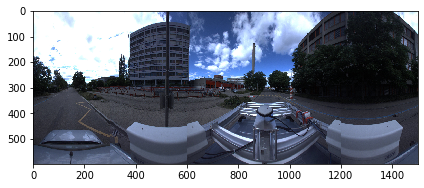

In [6]:
pano_stitch = np.concatenate(coll_pano, axis=1) # Teilstueck zu einem Bild zusammensetzen

# Resultat anzeigen
io.imshow(pano_stitch)
plt.show();

In [7]:
# Resultat speichern
pano_stitch_file = 'data/PanoStitch.jpg'
io.imsave(pano_stitch_file, pano_stitch) # Panoramabild abspeichern

### Visualisieren des Zylinderpanoramas im QuickTime Player
Für die Visualisierung des Panoramas im QuickTime Player wird das Panorama mittels der Software ``Pano2QTVR`` in ein QuickTime-Format konvertiert:
1. Öffnen Sie die Software <b>Pano2QTVR</b> unter ``src/pano_software/``
<figure align="left">
<img src="data/screenshots/pic1.png" alt="1" width="300"/>
</figure>

2. Erstellen Sie ein neues Projekt und speichern Sie es anschliessend
<figure align="left">
<img src="data/screenshots/pic2.png" alt="2" width="400"/>
</figure>

3. Wählen Sie den Panoramatyp "Cylindrical" und laden Sie das erstellte Panorama
<figure align="left">
<img src="data/screenshots/pic3.png" alt="3" width="400"/>
</figure>

4. Wechseln Sie vom Register <i>Project</i> zu <i>Settings</i>. Stellen Sie die Movie-Properties wie folgt ein und klicken Sie dann auf <i>Create</i>
<figure align="left">
<img src="data/screenshots/pic4.png" alt="4" width="400"/>
</figure>

5. Sie können nun die erstellte Datei mit dem QuickTime Player öffnen. Es ist jetzt möglich sich im Panorama zu bewegen sowie hinein und heraus zu zoomen